# Beijing Air Quality Forecasting Starter Notebook

In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')



In [63]:
# Load the datasets
train = pd.read_csv('../Datasets/train.csv')
test = pd.read_csv('../Datasets/test.csv')

# Display basic information about the training data
print("Training data shape:", train.shape)
print("\nTraining data info:")
train.info()
print("\nFirst few rows of training data:")
display(train.head())



Training data shape: (30676, 12)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB

First few rows of training data:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [64]:
# Check for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())




Missing values in training data:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [65]:
# Exploratory Data Analysis
print("\nSummary statistics:")
display(train.describe())




Summary statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


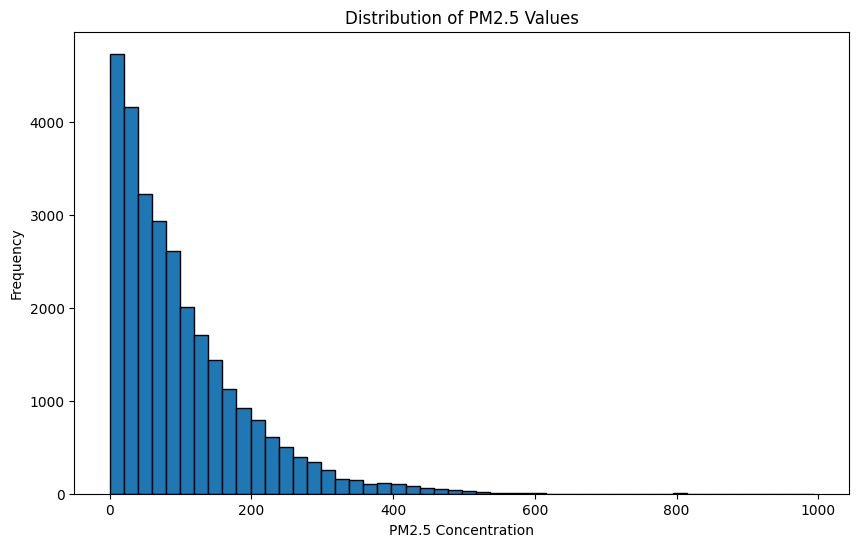

In [66]:
# Plot distribution of PM2.5 values
plt.figure(figsize=(10, 6))
plt.hist(train['pm2.5'], bins=50, edgecolor='black')
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()



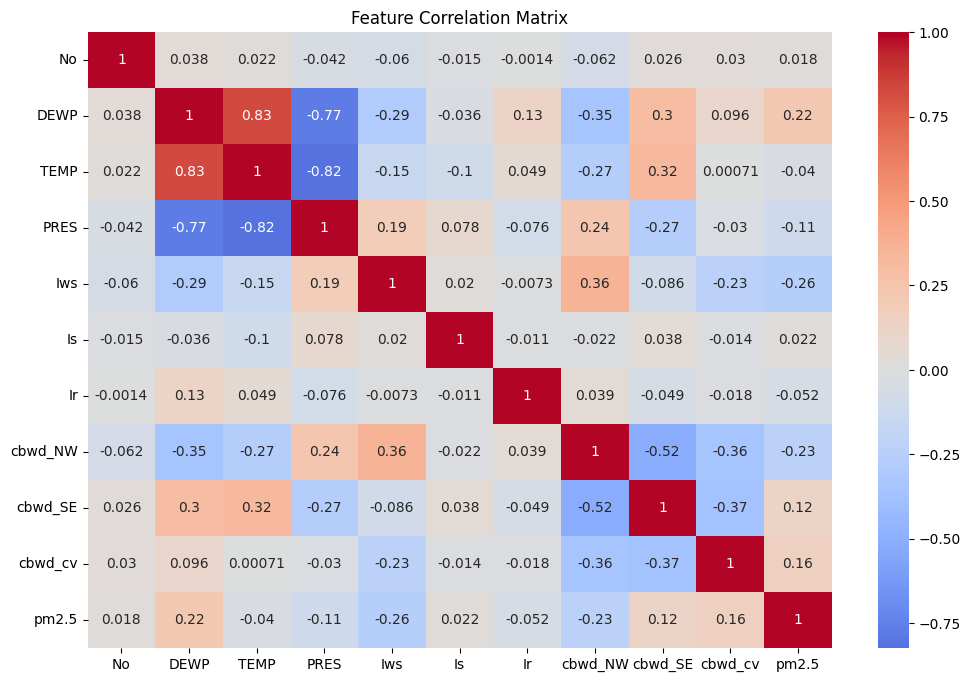

In [67]:
# Plot correlation matrix (only for numeric columns)
plt.figure(figsize=(12, 8))
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()



In [68]:
# Feature Engineering function that handles both train and test data
def create_features(df, is_train=True):
    df = df.copy()
    
    # Create time-based features
    if 'datetime' not in df.columns and 'No' in df.columns:
        # Assuming the data is in hourly intervals starting from 2010-01-01
        df['datetime'] = pd.date_range(start='2010-01-01', periods=len(df), freq='H')
    
    # Ensure datetime column is in datetime format
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['hour'] = df['datetime'].dt.hour
        df['day'] = df['datetime'].dt.day
        df['month'] = df['datetime'].dt.month
        df['day_of_week'] = df['datetime'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Create interaction features
    df['temp_dewp'] = df['TEMP'] * df['DEWP']
    df['pres_temp'] = df['PRES'] * df['TEMP']
    
    # Only create lag features for training data or if pm2.5 exists
    if is_train and 'pm2.5' in df.columns:
        for lag in [1, 2, 3, 6, 12, 24]:
            df[f'pm2.5_lag_{lag}'] = df['pm2.5'].shift(lag)
        
        # Drop rows with NaN values created by lag features
        df = df.dropna()
    
    return df

# Apply feature engineering to training data
train_featured = create_features(train, is_train=True)



In [69]:
# Prepare data for modeling
def prepare_data(df, target_col='pm2.5', sequence_length=24, is_train=True):
    # Separate features and target
    if is_train:
        X = df.drop(columns=[target_col, 'No', 'datetime'] if 'datetime' in df.columns else [target_col, 'No'])
        y = df[target_col]
    else:
        X = df.drop(columns=['No', 'datetime'] if 'datetime' in df.columns else ['No'])
        y = None
    
    # Scale features
    if is_train:
        scaler_x = RobustScaler()
        scaler_y = RobustScaler()
        
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_seq.append(X_scaled[i:i+sequence_length])
            y_seq.append(y_scaled[i+sequence_length])
        
        return np.array(X_seq), np.array(y_seq), scaler_x, scaler_y
    else:
        X_scaled = scaler_x.transform(X)
        
        # Create sequences
        X_seq = []
        for i in range(len(X_scaled) - sequence_length):
            X_seq.append(X_scaled[i:i+sequence_length])
        
        return np.array(X_seq), None

# Prepare the training data
SEQUENCE_LENGTH = 24
X_train, y_train, scaler_x, scaler_y = prepare_data(train_featured, is_train=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")



Training sequences: (21750, 24, 22)
Validation sequences: (5438, 24, 22)


In [71]:
# Build an improved LSTM model
def create_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model
# Create and display model summary
model = create_model((X_train.shape[1], X_train.shape[2]))
model.summary()





Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 24, 128)        │        44,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,817 (339.13 KB)

 Trainable params: 86,817 (339.13 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - loss: 0.2934 - mae: 0.3554 - val_loss: 0.1692 - val_mae: 0.2512 - learning_rate: 0.0010
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.1375 - mae: 0.2439 - val_loss: 0.1431 - val_mae: 0.2271 - learning_rate: 0.0010
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - loss: 0.1416 - mae: 0.2326 - val_loss: 0.1474 - val_mae: 0.2309 - learning_rate: 0.0010
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.1191 - mae: 0.2248 - val_loss: 0.1372 - val_mae: 0.2192 - learning_rate: 0.0010
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.1241 - mae: 0.2205 - val_loss: 0.1337 - val_mae: 0.2098 - learning_rate: 0.0010
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - loss: 0.1161 - mae: 0.2191 - val_loss: 0.1407 - val_mae: 0.2234 - learning_rate: 0.0010
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 68s 200ms/step - loss: 0.1112 - mae: 0.2129 - val_loss: 0.1407 - val_mae: 0.2208 - learning_rat

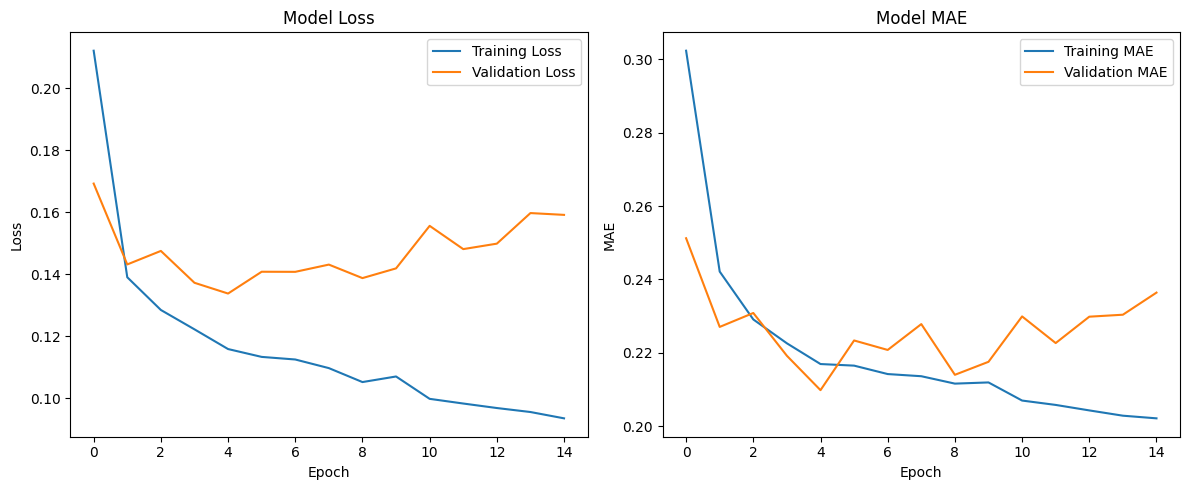

In [73]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()



In [76]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data(data, is_train=True, scaler_x=None, scaler_y=None):
    seq_length = 12  # Adjust based on your sequence length
    if is_train:
        X = data.drop(columns=['date', 'sales']).values
        y = data['sales'].values.reshape(-1, 1)
        
        # Initialize and fit scalers
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y).flatten()
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
            y_seq.append(y_scaled[i])
        return np.array(X_seq), np.array(y_seq), scaler_x, scaler_y
    else:
        # Use pre-fitted scalers for transformation
        X = data.drop(columns=['date', 'sales']).values
        X_scaled = scaler_x.transform(X)  # Now uses provided scaler_x
        
        # Create sequences (no y values needed for prediction)
        X_seq = []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
        return np.array(X_seq), None

In [78]:
print("Columns in train_featured:", train_featured.columns.tolist())

Columns in train_featured: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5', 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'temp_dewp', 'pres_temp', 'pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_lag_6', 'pm2.5_lag_12', 'pm2.5_lag_24']


In [82]:
def prepare_data(data, target_column='pm2.5', is_train=True, scaler_x=None, scaler_y=None):
    seq_length = 12
    
    # Identify feature columns (all columns except target)
    feature_columns = [col for col in data.columns if col != target_column]
    
    if is_train:
        X = data[feature_columns].values
        y = data[target_column].values.reshape(-1, 1)
        
        # Initialize and fit scalers
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y).flatten()
        
        # Create sequences
        X_seq, y_seq = [], []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
            y_seq.append(y_scaled[i])
        return np.array(X_seq), np.array(y_seq), scaler_x, scaler_y
    else:
        X = data[feature_columns].values
        X_scaled = scaler_x.transform(X)
        
        # Create sequences
        X_seq = []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
        return np.array(X_seq), None

In [84]:

from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_numeric_dtype

def prepare_data(data, target_column='pm2.5', is_train=True, scaler_x=None, scaler_y=None, seq_length=12):
    """
    Prepares sequences for training/prediction.
    - Drops non-numeric columns (e.g. 'datetime') and 'No'.
    - When is_train=True returns X_seq, y_seq, scaler_x, scaler_y.
    - When is_train=False returns X_seq, None (expects scaler_x provided).
    """
    df = data.copy()
    # drop known non-feature columns if present
    for c in ['No', 'datetime']:
        if c in df.columns:
            df = df.drop(columns=[c])

    # identify numeric feature columns only (exclude target)
    feature_columns = [col for col in df.columns if col != target_column and is_numeric_dtype(df[col])]
    if len(feature_columns) == 0:
        raise ValueError("No numeric feature columns found. Check your dataframe columns.")

    X = df[feature_columns].values

    if is_train:
        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in training data.")
        y = df[target_column].values.reshape(-1, 1)

        scaler_x = MinMaxScaler() if scaler_x is None else scaler_x
        scaler_y = MinMaxScaler() if scaler_y is None else scaler_y

        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y).flatten()

        X_seq, y_seq = [], []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
            y_seq.append(y_scaled[i])
        return np.array(X_seq), np.array(y_seq), scaler_x, scaler_y
    else:
        if scaler_x is None:
            raise ValueError("scaler_x must be provided when is_train=False")
        X_scaled = scaler_x.transform(X)
        X_seq = []
        for i in range(seq_length, len(X_scaled)):
            X_seq.append(X_scaled[i-seq_length:i])
        return np.array(X_seq), None

In [94]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

SAMPLE_PATH = Path(r"c:\Users\HP\Time-Series-Forecasting\Datasets\sample_submission .csv")
OUT_PATH = Path(r"c:\Users\HP\Time-Series-Forecasting\Datasets\submission.csv")

if not SAMPLE_PATH.exists():
    raise FileNotFoundError(f"sample_submission not found at {SAMPLE_PATH}")

sample = pd.read_csv(SAMPLE_PATH)
print("Sample submission columns:", sample.columns.tolist())
print("Sample shape:", sample.shape)

# Ensure predictions exist, else attempt to create them
if 'y_test_pred' not in globals():
    print("y_test_pred not found — attempting to build X_test_seq and predict using existing model/scalers.")
    # Rebuild X_test_seq if necessary (will raise helpful errors if prerequisites missing)
    if 'X_test_seq' not in globals():
        if 'test_featured' not in globals():
            if 'test' in globals() and 'create_features' in globals():
                test_featured = create_features(test, is_train=False)
            else:
                raise NameError("test_featured not found and cannot be built. Run create_features(test) first.")
        if 'scaler_x' not in globals():
            raise NameError("scaler_x not found. Run training prepare_data(...) and keep scaler_x.")
        X_test_seq = None
        try:
            # reuse prepare_data if available
            if 'prepare_data' in globals():
                X_test_seq, _ = prepare_data(test_featured, target_column='pm2.5', is_train=False, scaler_x=scaler_x, scaler_y=scaler_y if 'scaler_y' in globals() else None, seq_length=SEQUENCE_LENGTH)
            else:
                # fallback sequence builder using scaler_x.feature_names_in_ or inferred feature list
                feature_cols = list(getattr(scaler_x, 'feature_names_in_', []))
                if not feature_cols:
                    feature_cols = [c for c in test_featured.columns if c != 'pm2.5' and pd.api.types.is_numeric_dtype(test_featured[c])]
                test_copy = test_featured.copy()
                for c in feature_cols:
                    if c not in test_copy.columns:
                        test_copy[c] = 0.0
                test_copy = test_copy[feature_cols]
                X_test_scaled = scaler_x.transform(test_copy.values)
                def make_sequences(X_arr, window):
                    Xs = []
                    for i in range(len(X_arr) - window):
                        Xs.append(X_arr[i:i+window])
                    return np.array(Xs)
                X_test_seq = make_sequences(X_test_scaled, SEQUENCE_LENGTH)
        except Exception as e:
            raise RuntimeError(f"Failed to build X_test_seq: {e}")

    if X_test_seq is None or X_test_seq.size == 0:
        raise ValueError("X_test_seq is empty or not built correctly. Check SEQUENCE_LENGTH and test size.")
    if 'model' not in globals():
        raise NameError("model not available to make predictions.")
    preds_scaled = model.predict(X_test_seq, batch_size=128)
    if 'scaler_y' in globals():
        y_test_pred = scaler_y.inverse_transform(preds_scaled).flatten()
    elif 'target_scaler' in globals():
        y_test_pred = target_scaler.inverse_transform(preds_scaled).flatten()
    else:
        y_test_pred = preds_scaled.flatten()

# Build a DataFrame for our predictions with datetimes if possible
if 'test_featured' in globals() and 'datetime' in test_featured.columns:
    pred_datetimes = test_featured['datetime'].iloc[SEQUENCE_LENGTH:SEQUENCE_LENGTH + len(y_test_pred)].reset_index(drop=True)
    df_preds = pd.DataFrame({'datetime': pd.to_datetime(pred_datetimes), 'pm2.5': y_test_pred})
else:
    df_preds = pd.DataFrame({'pm2.5': y_test_pred})

# Decide how to fill sample_submission
target_col = None
if 'pm2.5' in sample.columns:
    target_col = 'pm2.5'
else:
    # find numeric candidate columns excluding common id columns
    numeric_cols = sample.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c.lower() not in ('row_id','id','index')]
    if len(numeric_cols) == 1:
        target_col = numeric_cols[0]
    elif 'target' in sample.columns:
        target_col = 'target'
    else:
        # fallback to last column
        target_col = sample.columns[-1]

print(f"Detected submission target column: {target_col}")

# If sample has datetime, try merge on datetime
if 'datetime' in sample.columns and 'datetime' in df_preds.columns:
    sample['datetime'] = pd.to_datetime(sample['datetime'])
    merged = sample.merge(df_preds, on='datetime', how='left', suffixes=('', '_pred'))
    if target_col in merged.columns and 'pm2.5' in merged.columns:
        # prefer merged 'pm2.5' predictions
        merged[target_col] = merged['pm2.5'].fillna(merged.get(target_col, 0))
    elif 'pm2.5' in merged.columns:
        merged[target_col] = merged['pm2.5'].fillna(0)
    else:
        raise RuntimeError("Merge produced no prediction column. Check datetime formats.")
    final = merged[sample.columns]  # preserve original column order
    # fill any remaining NaNs in target_col with 0
    final[target_col] = final[target_col].fillna(0)
else:
    # No datetime to merge on — align by length / position
    if len(df_preds) == len(sample):
        sample[target_col] = df_preds['pm2.5'].values
        final = sample
    elif len(df_preds) < len(sample):
        # place predictions at the end (typical if sequences consume initial rows)
        pad = len(sample) - len(df_preds)
        sample[target_col] = 0
        sample.iloc[pad:, sample.columns.get_loc(target_col)] = np.round(df_preds['pm2.5'].values).astype(int)
        final = sample
        warnings.warn(f"Predictions shorter than sample_submission ({len(df_preds)} vs {len(sample)}). Placed predictions at last {len(df_preds)} rows.")
    else:
        # more preds than sample — truncate to match sample length (take last rows)
        sample[target_col] = np.round(df_preds['pm2.5'].values[-len(sample):]).astype(int)
        final = sample
        warnings.warn(f"More predictions ({len(df_preds)}) than sample rows ({len(sample)}). Truncated to match sample length.")

# Ensure integer and non-negative if required
if final[target_col].dtype.kind in 'fc':
    try:
        final[target_col] = np.clip(np.round(final[target_col]), 0, None).astype(int)
    except Exception:
        pass

# Quick checks
print("Final submission shape:", final.shape)
if final.isnull().any().any():
    warnings.warn("Submission contains NaNs — these will be filled with 0.")
    final = final.fillna(0)

final.to_csv(OUT_PATH, index=False)
print(f"Saved submission to {OUT_PATH}")
print("If Kaggle still says a column is missing, open the sample_submission and check expected column names (row_id / datetime / target).")

Sample submission columns: ['row ID', 'pm2.5']
Sample shape: (13148, 2)
Detected submission target column: pm2.5
Final submission shape: (13148, 2)
Saved submission to c:\Users\HP\Time-Series-Forecasting\Datasets\submission.csv
If Kaggle still says a column is missing, open the sample_submission and check expected column names (row_id / datetime / target).
